In [2]:
# Constants

EPOCHS:int = 20
NUM_WORKERS:int = 8

# Helpful links
# 
# https://github.com/dougbrion/pytorch-deep-ensembles/blob/main/development.ipynb

In [3]:
import regression
import torch
from torch.utils.data import TensorDataset, DataLoader

train_x, test_x, train_y, test_y = regression.regression_dataset()

def create_data_loader(x: torch.Tensor, y: torch.Tensor, batch_size:int, num_workers:int) -> DataLoader:
    dataset = TensorDataset(x, y)
    return DataLoader(dataset=dataset, batch_size=batch_size, num_workers=num_workers)

train_loader = create_data_loader(train_x, train_y, batch_size=32, num_workers=NUM_WORKERS)
test_loader = create_data_loader(test_x, test_y, batch_size=32, num_workers=NUM_WORKERS)


In [4]:
import pytorch_lightning as pl
from torch import nn
from torch.nn import functional
import torch


# TODO make a reasonable ann class
class ANN(pl.LightningModule):

    def __init__(self, loss_function):
        super(ANN, self).__init__()        
        self.loss_function = loss_function
        self.h1 = nn.Sequential(
            nn.Linear(in_features=(1), out_features=20),
            nn.ReLU(),
        )
        # fully connected layer, output 10 classes
        self.h2 = nn.Sequential(
            nn.Linear(in_features=20, out_features=10),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.Linear(in_features=10, out_features=1),
        )

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)        
        output = self.out(x)
        return output

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        out = self.forward(x)

        loss = self.loss_function(out, y)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        out = self.forward(x)
        test_loss = self.loss_function(out, y)
        self.log("test_loss", test_loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self.forward(x)
        validiation_loss = self.loss_function(out, y)
        self.log("validation_loss", validiation_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [5]:
loss_function = functional.mse_loss

m1 = ANN(loss_function=loss_function)

In [6]:
trainer = pl.Trainer(max_epochs=EPOCHS)
trainer.fit(model=m1, train_dataloaders=train_loader)

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torch/cuda/__init__.py:82: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defi

Training: 0it [00:00, ?it/s]

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


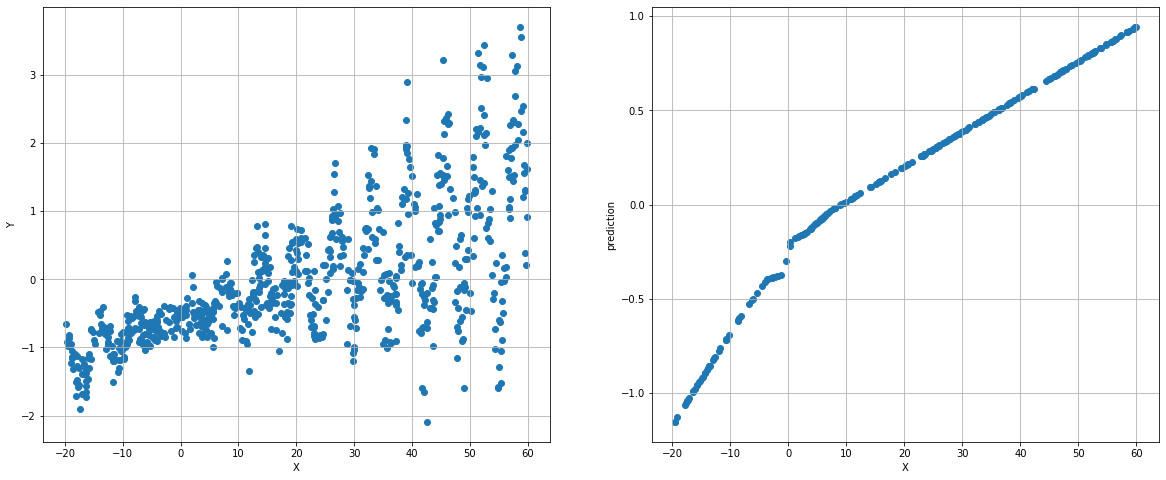

In [7]:
import matplotlib.pyplot as plt
from typing import Any
%matplotlib inline

def plot(x: torch.Tensor, y: torch.Tensor, ax: plt.Axes, x_label:str="X", y_label:str="Y") -> None:
    ax.scatter(x.numpy(), y.numpy())
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.grid(True)


predictions = m1(test_x).detach()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
plot(train_x, train_y, ax1)
plot(test_x, predictions, ax2, y_label="prediction")
plt.show()


# Observations:

- Regression ANN can not predict uncertainty we see in the data

# Part B

In [8]:
class GausianANN(pl.LightningModule):

    def __init__(self):
        super(GausianANN, self).__init__()        
        self.h1 = nn.Sequential(
            nn.Linear(in_features=(1), out_features=20),
            nn.ReLU(),
        )
        # fully connected layer, output 10 classes
        self.h2 = nn.Sequential(
            nn.Linear(in_features=20, out_features=10),
            nn.ReLU()
        )

        self.out = nn.Sequential(
            nn.Linear(in_features=10, out_features=2),
        )

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)        
        output = self.out(x)
        mean, variance = torch.split(output, 1, dim=1)
        return mean, functional.softplus(variance) + 1e-6

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x, y = batch
        mean, var = self.forward(x)

        loss = functional.gaussian_nll_loss(mean, y, var)
        self.log("train_loss", loss)
        return loss

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x, y = batch
        mean, var = self.forward(x)

        loss = functional.gaussian_nll_loss(mean, y, var)
        self.log("test_loss", loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        mean, var = self.forward(x)

        loss = functional.gaussian_nll_loss(mean, y, var)
        self.log("validation_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

In [9]:
m2 = GausianANN()


In [10]:
trainer = pl.Trainer(max_epochs=EPOCHS)
trainer.fit(model=m2, train_dataloaders=train_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:133: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)
/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1933: PossibleUserWarning: The number of training batche

Training: 0it [00:00, ?it/s]

/home/paul/PycharmProjects/trustworthy_machine_learning/venv/lib/python3.9/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (_ResultMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_no_full_state`
                that can be used to check if the `full_state_update=True` (old and potential slower behaviour,
                default for now) or if `full_state_update=False` can be used safely.
                
  warnings.warn(*args, **kwargs)


In [11]:
means, vars = m2(test_x)

In [12]:
upper = means + torch.sqrt(vars)
lower = means - torch.sqrt(vars)

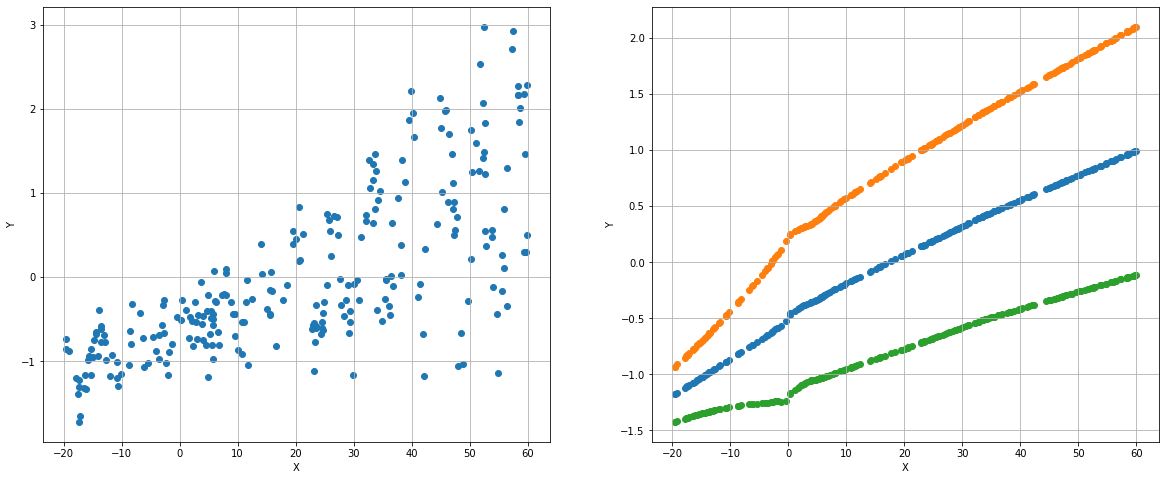

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

plot(test_x, test_y, ax1)
plot(test_x, means.detach(), ax2)
plot(test_x, upper.detach(), ax2)
plot(test_x, lower.detach(), ax2)

# Part C

In [14]:
# Train ensamble with 20 members

def train_model(model): 
    t = pl.Trainer(max_epochs=EPOCHS)
    t.fit(model=model, train_dataloaders=train_loader)
    return model

models = [train_model(GausianANN()) for _ in range(20)]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name | Type       | Params
------------------------------------
0 | h1   | Sequential | 40    
1 | h2   | Sequential | 210   
2 | out  | Sequential | 22    
------------------------------------
272       Trainable params
0         Non-trainable params
272       Total params
0.001     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

In [17]:
outputs = [model(test_x) for model in models]
means = torch.mean(torch.stack([m.detach() for m, _ in outputs]), dim=0)
vars = torch.mean(torch.stack([v.detach() for _, v in outputs]), dim=0)

upper = means + torch.sqrt(vars)
lower = means - torch.sqrt(vars)

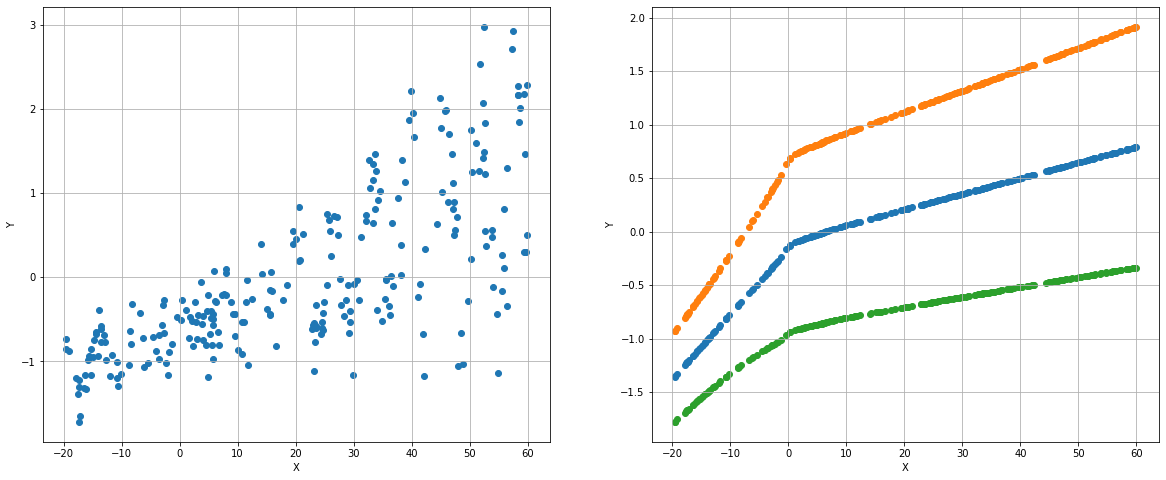

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

plot(test_x, test_y, ax1)
plot(test_x, means.detach(), ax2)
plot(test_x, upper.detach(), ax2)
plot(test_x, lower.detach(), ax2)